Ở các bài trước, chúng ta đã được làm quen với các thuật toán xử lý ảnh cơ bản. Các thuật toán này hoàn toàn có thể được áp dụng để phát hiện làn đường trong ảnh hết sức dễ dàng. Ở phần này, chúng ta sẽ cùng xây dựng thuật toán phát hiện vạch kẻ đường từ đầu bằng các kĩ thuật xử lý ảnh như chuyển đổi hệ màu, lọc nhiễu, phát hiện cạnh.





In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from imutils import paths
import numpy as np
import os
import glob
import cv2
import math
%matplotlib inline


## 1. Tải dữ liệu mẫu

Trước hết cần tải về dữ liệu mẫu để thử nghiệm. Dữ liệu này bao gồm 10 ảnh chụp từ góc nhìn của xe mô hình giả lập, xây dựng từ [bộ giả lập lái xe của Udacity](https://github.com/udacity/self-driving-car-sim). Chúng ta sẽ lập trình nhận dạng vạch kẻ đường từ các hình ảnh giả lập này. Lệnh `wget` bên dưới sẽ giúp chúng ta tải về tệp dữ liệu, tiếp đó lệnh `unzip` sẽ giúp giải nén tệp dữ liệu này.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import random

# def get_image_file_paths(folder_path):
#     # Lấy danh sách tên các tệp ảnh trong thư mục
#     image_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

#     # Kết hợp tên tệp với đường dẫn thư mục để có đường dẫn tệp hoàn chỉnh
#     image_file_paths = [os.path.join(folder_path, image_name) for image_name in image_names]

#     return image_file_paths

def get_image_file_paths(folder_path, num_images=6):
    # Get a list of all image file names in the folder
    image_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

    # Shuffle the list of image file names to randomize the selection
    random.shuffle(image_names)

    # Take the first 'num_images' images from the shuffled list
    selected_image_names = image_names[:num_images]

    # Combine the selected image names with the folder path to get complete file paths
    selected_image_file_paths = [os.path.join(folder_path, image_name) for image_name in selected_image_names]

    return selected_image_file_paths

# Example usage: Get 6 random image file paths from a folder
folder_path = '/content/drive/MyDrive/via-trafficsign/images/train'
image_names = get_image_file_paths(folder_path, num_images=12)

# In danh sách đường dẫn tệp ảnh
print(image_names)

['/content/drive/MyDrive/via-trafficsign/images/train/06782.jpg', '/content/drive/MyDrive/via-trafficsign/images/train/01755.jpg', '/content/drive/MyDrive/via-trafficsign/images/train/00424.jpg', '/content/drive/MyDrive/via-trafficsign/images/train/05443.jpg', '/content/drive/MyDrive/via-trafficsign/images/train/06086.jpg', '/content/drive/MyDrive/via-trafficsign/images/train/09363.jpg', '/content/drive/MyDrive/via-trafficsign/images/train/05621.jpg', '/content/drive/MyDrive/via-trafficsign/images/train/09146.jpg', '/content/drive/MyDrive/via-trafficsign/images/train/02080.jpg', '/content/drive/MyDrive/via-trafficsign/images/train/07940.jpg', '/content/drive/MyDrive/via-trafficsign/images/train/02905.jpg', '/content/drive/MyDrive/via-trafficsign/images/train/00916.jpg']


## 2. Hiện ảnh

Hàm `show_images()` được chúng tôi viết sẵn để hiện ảnh trên notebook này, nó sẽ giúp chúng ta hiện nhiều ảnh cùng lúc trên file Notebook. Việc hiện ảnh trên các Notebook của Colab được thực hiện với hàm `plt.imshow()` từ thư viện `matplotlib`.

In [ ]:
def show_images(images, cmap="viridis"):
    column = 3
    row = int(math.ceil(len(images)/column))
    plt.figure(figsize=(20, 10))
    for i, img in enumerate(images):
        plt.subplot(row,column,i+1)
        if cmap != "gray":
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img, cmap=cmap)
        plt.axis('off')

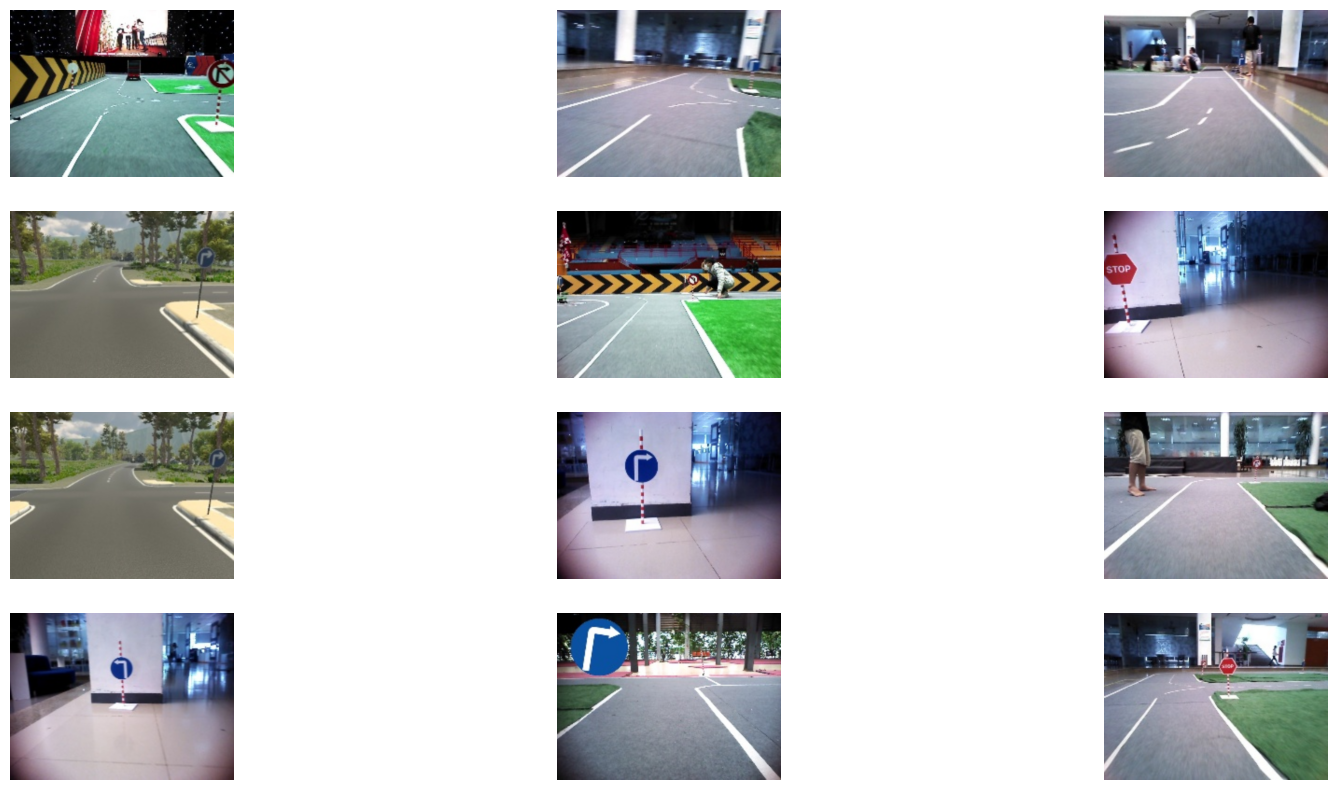

In [ ]:
## Đọc tất cả ảnh vào biến bgr_images và hiện lên
bgr_images = [cv2.imread(name) for name in image_names]

# Assuming bgr_images is a list of BGR images you've read using cv2.imread
new_width = 640  # Change to your desired width
new_height = 480  # Change to your desired height

# List to store resized images
resized_images = []

# Iterate through the list of BGR images and resize each one
for img in bgr_images:
    # Resize the image to the new width and height
    resized_img = cv2.resize(img, (new_width, new_height))

    # Append the resized image to the list
    resized_images.append(resized_img)
bgr_images = resized_images
show_images(bgr_images)

In [ ]:
def enhance_white_color(image, gamma=5):
        # Convert the input image to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Apply histogram equalization to enhance contrast
        equ = cv2.equalizeHist(gray)

        # Convert back to color image with enhanced white color
        enhanced_img = cv2.cvtColor(equ, cv2.COLOR_GRAY2BGR)

        # Apply gamma correction for contrast adjustment
        inv_gamma = 1.0 / gamma
        enhanced_img = np.power(enhanced_img / 255.0, inv_gamma)
        enhanced_img = np.uint8(enhanced_img * 255)
        return enhanced_img

def shadow_remove(img):
    rgb_planes = cv2.split(img)
    result_norm_planes = []
    for plane in rgb_planes:
        dilated_img = cv2.dilate(plane, np.ones((7,7), np.uint8))
        bg_img = cv2.medianBlur(dilated_img, 21)
        diff_img = 255 - cv2.absdiff(plane, bg_img)
        norm_img = cv2.normalize(diff_img,None, alpha=0, beta=200, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
        result_norm_planes.append(norm_img)
    shadowremove = cv2.merge(result_norm_planes)
    return shadowremove

def birdview_transform(image):
    """
        Apply bird-view transform to the image
    """
    IMAGE_H = 480
    IMAGE_W = 640
    src = np.float32([[0, IMAGE_H], [640, IMAGE_H], [0, IMAGE_H * 0.4], [IMAGE_W, IMAGE_H * 0.4]])
    dst = np.float32([[240, IMAGE_H], [640 - 240, IMAGE_H], [-160, 0], [IMAGE_W+160, 0]])
    M = cv2.getPerspectiveTransform(src, dst) # The transformation matrix
    warped_img = cv2.warpPerspective(image, M, (IMAGE_W, IMAGE_H)) # Image warping
    return warped_img

# def birdview_transform(image):
#     """
#         Apply bird-view transform to the image
#     """
#     IMAGE_H = 180
#     IMAGE_W = 240
#     src = np.float32([[0, IMAGE_H], [240, IMAGE_H], [0, IMAGE_H * 0.4], [IMAGE_W, IMAGE_H * 0.4]])
#     dst = np.float32([[90, IMAGE_H], [240 - 90, IMAGE_H], [-60, 0], [IMAGE_W+60, 0]])
#     M = cv2.getPerspectiveTransform(src, dst) # The transformation matrix
#     warped_img = cv2.warpPerspective(image, M, (IMAGE_W, IMAGE_H)) # Image warping
#     return warped_img

def draw_image_with_filled_contour(mask):
    # Create a copy of the mask
    mask_copy = mask.copy()

    # Draw a white line at the bottom of the mask
    cv2.line(mask_copy, (0, mask_copy.shape[0] - 1), (mask_copy.shape[1], mask_copy.shape[0] - 1), (255, 255, 255), 2)
    # Thực hiện flood fill sau khi đã vẽ dòng trắng

    # Tìm các contour trong mask_copy
    contours, hierarchy = cv2.findContours(mask_copy, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Chuyển mask_copy sang ảnh RGB để vẽ contour
    mask_rgb = cv2.cvtColor(mask_copy, cv2.COLOR_GRAY2RGB)
    # Tạo một ảnh trắng với cùng kích thước như mask_copy
    filled_contour = np.ones_like(mask_rgb) * 255

    for i, contour in enumerate(contours):
        # Lấy thông tin về phần tử cha của contour
        parent_idx = hierarchy[0][i][3]

        # Nếu không có phần tử cha (parent_idx == -1), vẽ contour
        if parent_idx == -1:

            area = cv2.contourArea(contour)
            if area >= 500:
                # Vẽ contour lên mask_rgb
                # cv2.drawContours(mask_rgb, [contour], -1, (0, 255, 0), 2)

                # Vẽ filled contour bằng màu trắng
                cv2.fillPoly(mask_rgb, [contour], (255, 255, 255))
            else:
                # Nếu diện tích nhỏ hơn 2200, vẽ filled contour bằng màu đen
                cv2.fillPoly(filled_contour, [contour], (0, 0, 0))
        else:
            # Vẽ filled contour bằng màu trắng cho các contour con
            cv2.fillPoly(filled_contour, [contour], (255, 255, 255))

    # Tạo ảnh mới bằng phép giao giữa ảnh ban đầu và filled_contour
    new_image = cv2.bitwise_and(mask_rgb, filled_contour)
    #convert new_image to binary image
    new_image = cv2.cvtColor(new_image, cv2.COLOR_RGB2GRAY)
    # new_image = shadow_remove(new_image)

    return new_image

def apply_canny_filter_and_display(image):

    image = cv2.GaussianBlur(image, (5, 5), 0)

    # filter for blue lane lines
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # lọc màu trắng làn đường
    #(hMin = 2 , sMin = 8, vMin = 96), (hMax = 36 , sMax = 49, vMax = 231)
    lower1, upper1 = np.array([0, 0, 196]), np.array([179, 12, 255])
    #(hMin = 0 , sMin = 0, vMin = 45), (hMax = 127 , sMax = 63, vMax = 162)
    lower2, upper2 = np.array([15, 0, 222]), np.array([103, 66, 255])
    #(hMin = 0 , sMin = 0, vMin = 0), (hMax = 39 , sMax = 255, vMax = 104)
    # lower3, upper3 = np.array([0, 0, 0]), np.array([39, 255, 104]) #lọc màu đất .
    #(hMin = 0 , sMin = 0, vMin = 0), (hMax = 45 , sMax = 28, vMax = 105)

    mask_1 = cv2.inRange(hsv, lower1, upper1) # dải màu đỏ thứ nhất
    mask_2 = cv2.inRange(hsv, lower2, upper2) # dải màu đỏ thứ hai
    # mask_3 = cv2.inRange(hsv, lower3, upper3) # dải màu đỏ thứ ba

    mask_r = cv2.bitwise_or(mask_1, mask_2) # kết hợp 2 kết quả từ 2 dải màu khác nhau
    # mask_r = cv2.subtract(mask_r, mask_3) # kết hợp kết quả từ 3 dải màu khác nhau

    contours, _ = cv2.findContours(mask_r, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    min_contour_area = 5  # Adjust this threshold as needed
    filtered_edges = np.zeros_like(mask_r)
    for contour in contours:
        if cv2.contourArea(contour) > min_contour_area:
            cv2.drawContours(filtered_edges, [contour], 0, 255, thickness=-1)

    img_gauss = cv2.GaussianBlur(mask_r, (3, 3), 0)
    fill_image = draw_image_with_filled_contour(img_gauss)
    edges = cv2.Canny(fill_image, 0, 200)

    kernel = np.ones((5, 5), np.uint8)  # Adjust the kernel size as needed
    merged_edges = cv2.dilate(edges, kernel, iterations=1)

    height = merged_edges.shape[0]
    two_thirds_height = (2 * height) // 3
    two_thirds_height = height - two_thirds_height
    img_thresholded = merged_edges.copy()
    img_thresholded[:two_thirds_height, :] = 0

    return img_thresholded

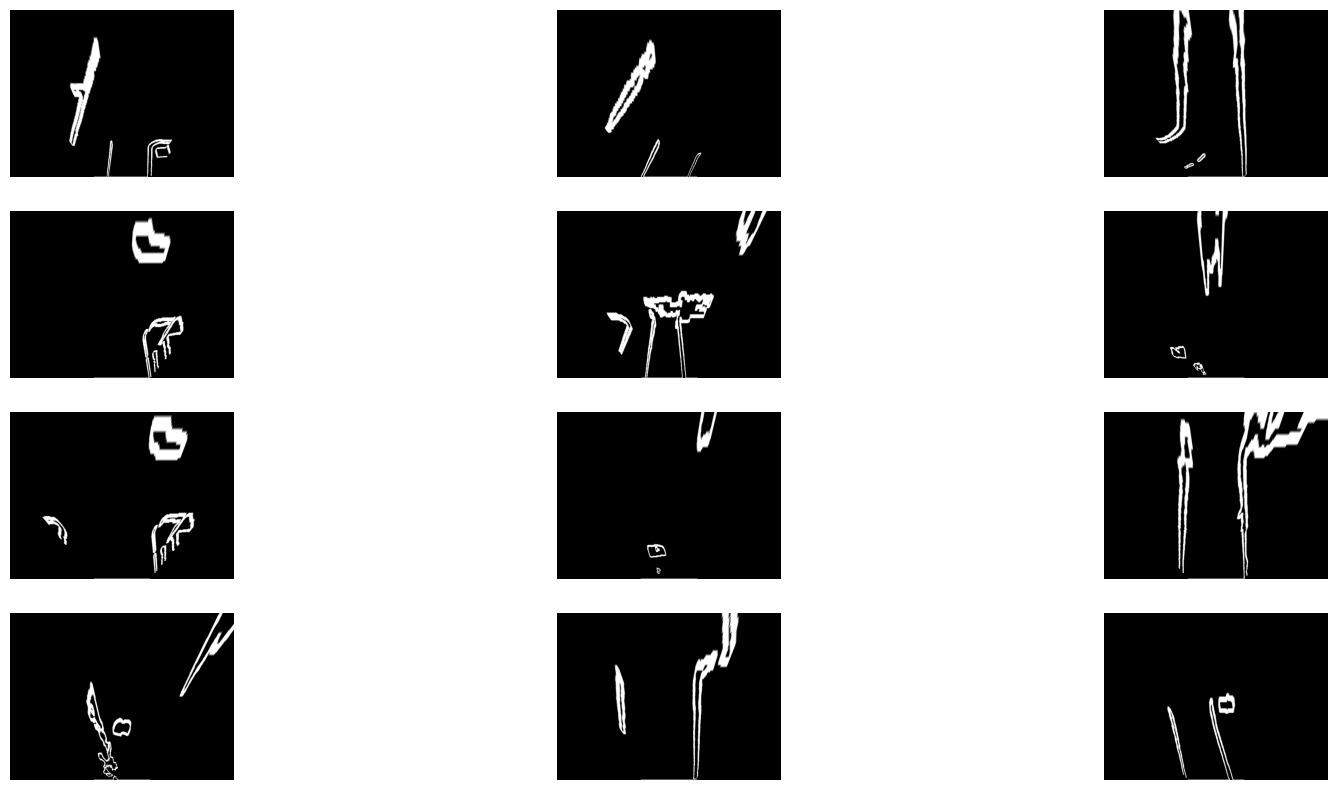

In [ ]:
list_img_lines = []
for img in bgr_images:
    # img_lines = find_lane_lines(img) # lọc gausian
    edge = apply_canny_filter_and_display(img)
    img_birdview = birdview_transform(edge)
    list_img_lines.append(img_birdview)

# Hiện toàn bộ kết quả
show_images(list_img_lines)

In [ ]:
def find_left_middle_right_points(image, draw=False):

    im_height, im_width = image.shape[:2]
    if draw:
        viz_img = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    # Vạch kẻ sử dụng để xác định tâm đường
    interested_line_y = int(im_height * 0.79)
    if draw:
        cv2.line(viz_img, (0, interested_line_y), (im_width, interested_line_y), (0, 0, 255), 2)
    interested_line = image[interested_line_y, :]

    # Lane width and center
    lane_width = 30
    center = im_width // 2

    # Search for points on each lane
    def search_lane_points(start, end, step, threshold):
        for x in range(start, end, step):
            if interested_line[x] > threshold:
                return x
        return 0

    # Find points for the left lane
    left_point = search_lane_points(0, center -lane_width, 1, 0)

    # Find points for the middle lane (around the center line)
    middle_point = search_lane_points(left_point + lane_width, center + lane_width, 1, 0)

    # Find points for the right lane
    right_point = search_lane_points(im_width-1, middle_point +lane_width, -1, 0)


    # Vẽ ba điểm trái, giữa và phải lên ảnh
    if draw:
        if left_point != 0:
            viz_img = cv2.circle(viz_img, (left_point, interested_line_y), 7, (255, 255, 0), -1)
        if middle_point != 0:
            viz_img = cv2.circle(viz_img, (middle_point, interested_line_y), 7, (0, 255, 255), -1)
        if right_point != 0:
            viz_img = cv2.circle(viz_img, (right_point, interested_line_y), 7, (0, 255, 0), -1)

    return left_point, right_point, viz_img

In [ ]:
def find_left_right_points(image, draw=False):

    im_height, im_width = image.shape[:2]
    if draw: viz_img = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    # Vạch kẻ sử dụng để xác định tâm đường
    interested_line_y = int(im_height * 0.79)
    if draw: cv2.line(viz_img, (0, interested_line_y), (im_width, interested_line_y), (0, 0, 255), 2)
    interested_line = image[interested_line_y, :]

    # Xác định điểm bên trái và bên phải
    left_point = -1
    right_point = -1
    lane_width = 100
    center = im_width // 2

    # Tìm điểm bên trái và bên phải bằng cách duyệt từ tâm ra
    for x in range(center, 0, -1):
        if interested_line[x] > 0:
            left_point = x
            break
    for x in range(center + 1, im_width):
        if interested_line[x] > 0:
            right_point = x
            break

    # # Dự đoán điểm bên phải khi chỉ nhìn thấy điểm bên trái
    # if left_point != -1 and right_point == -1:
    #     right_point = left_point + lane_width

    # # Dự đoán điểm bên trái khi chỉ thấy điểm bên phải
    # if right_point != -1 and left_point == -1:
    #     left_point = right_point - lane_width




    # Vẽ hai điểm trái / phải lên ảnh
    if draw:
        if left_point != -1:
            viz_img = cv2.circle(viz_img, (left_point, interested_line_y), 7, (255,255,0), -1)
        if right_point != -1:
            viz_img = cv2.circle(viz_img, (right_point, interested_line_y), 7, (0,255,0), -1)

    return left_point, right_point, viz_img


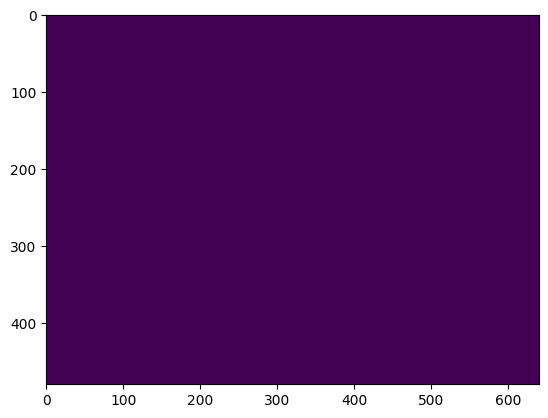

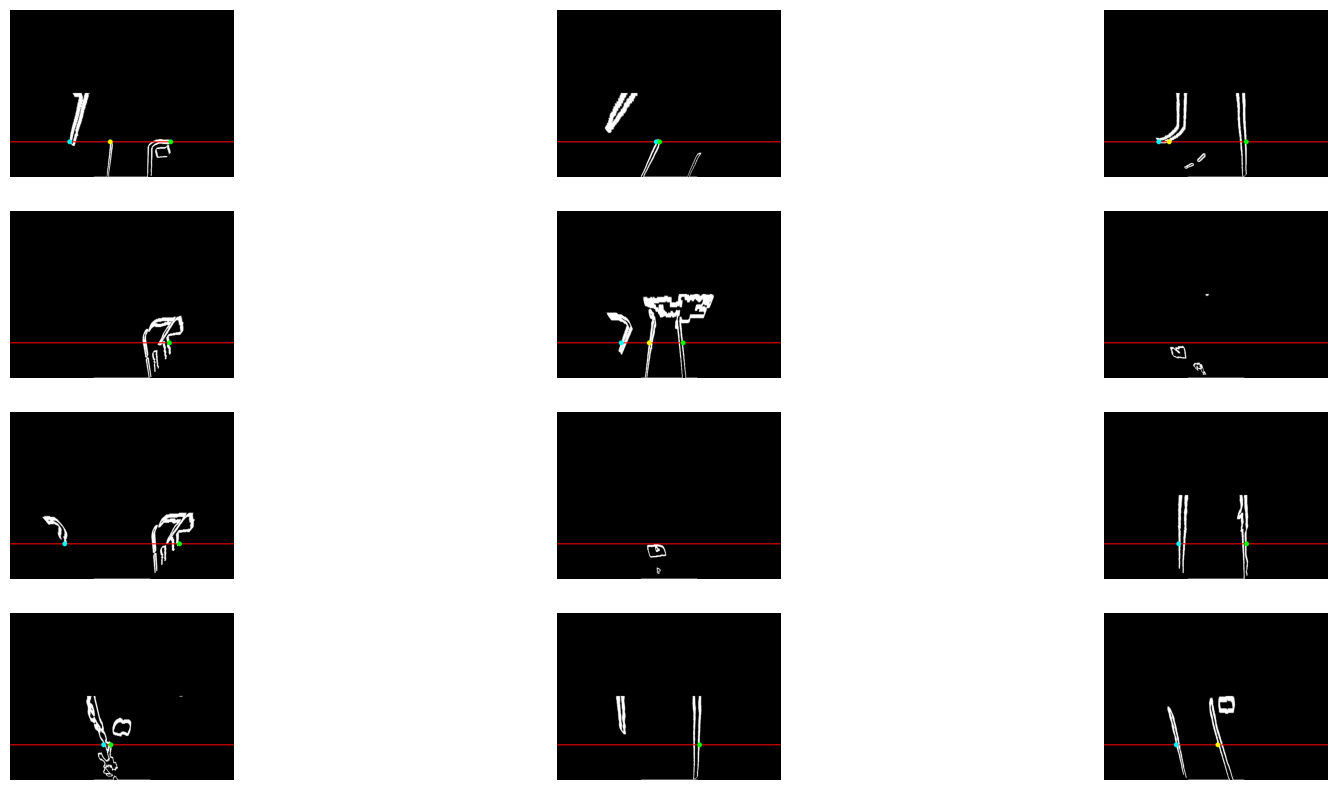

In [ ]:

viz_images = []
for img in list_img_lines:
    img_interest = region_of_interest(img)
    left_point, right_point, viz_img = find_left_middle_right_points(img_interest, draw=True)
    viz_images.append(viz_img)

show_images(viz_images)